# [Task 1] Named Entity Recognition  |  LSTM  |  PyTorch + Keras

Import Libraries.

In [1]:
import re
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
import matplotlib.pyplot as plt
from collections import Counter
from pandas.io.json import json_normalize

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

from sklearn_crfsuite import metrics

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
%matplotlib inline
sns.set_style("dark")

## Util

Function to read json files.

In [3]:
def read_json(path):
    file = json.loads(open(path).read())
    
    return file

Function to extract words from text based on the indices.

In [4]:
def extract_word(begin, end, txt):
    return txt[begin:end]

In [5]:
base_dir = "../../data/AGAC_training-annotations/AGAC_training/json/"

## Prepare Data

BIO labelling of data.  

In [6]:
word_label_dict = {}

    
for f in os.listdir(base_dir):
    file = read_json(base_dir + f)
    # Extract the document ID from the file name
    doc_id = "".join(re.findall(r'\d', f))
    txt = file['text']


    for i in range(len(file['denotations'])):
        b = file['denotations'][i]['span']['begin']
        e = file['denotations'][i]['span']['end']
        word = extract_word(b, e, txt)
        word_split = word.split(' ')
        obj = file['denotations'][i]['obj']

        # If length of word (after splitting on " ") is more than 2
        # Put 'B/I' labels
        if len(word_split) == 2:
            b_word = word_split[0]
            i_word = word_split[-1]
            b_obj = "B-" + obj
            i_obj = "I-" + obj
            word_label_dict[i_word] = i_obj
            word_label_dict[b_word] = b_obj

        # If length of word (after splitting on " ") is equal to 1
        # Put a 'B' label
        else:
            b_word = word_split[0]
            b_obj = "B-" + obj

            word_label_dict[b_word] = b_obj

Clean the data and put the label 'O' where necessary.

In [7]:
final_list = []

for f in os.listdir(base_dir):
    file = read_json(base_dir + f)
    doc_id = "".join(re.findall(r'\d', f))
    txt = file['text']

    # Clean the text data
    txt = re.sub(r'\n', " ", txt)
    txt = re.sub(r'\.', "", txt)
    txt = re.sub(r',', "", txt)
    txt = re.sub(r':', "", txt)


    txt_split = txt.split(" ")

    # Put a label 'O' for words that do not appear
    # in word_label_dict
    for w in txt_split:
        if w in word_label_dict.keys():
            final_list.append((doc_id, w, word_label_dict[w]))
        else:
            final_list.append((doc_id, w, "O"))

In [8]:
data_df = pd.DataFrame(final_list, columns=['doc_id', 'word', 'obj'])

In [9]:
data_df.head()

,doc_id,word,obj
0,30442766,LZTR1,B-Gene
1,30442766,is,O
2,30442766,a,O
3,30442766,regulator,O
4,30442766,of,O


## EDA

### Count of words/obj per document.

In [10]:
data_df.groupby('doc_id').count().head()

,word,obj
doc_id,,
16371368,307,307
17435236,229,229
18031991,235,235
18594199,189,189
19338054,265,265


### Stats about the data.

In [11]:
data_df.describe()

,doc_id,word,obj
count,55808,55808,55808
unique,250,9744,25
top,28283687,of,O
freq,513,2206,35790


### Frequncy of different output labels.

Frequency with label 'O'.

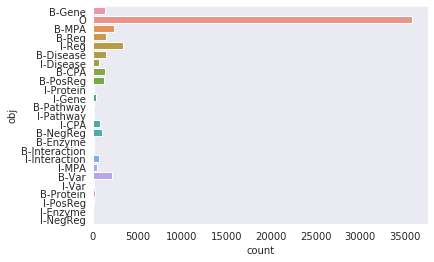

In [12]:
sns.countplot(y = "obj", data=data_df)

Frequency without label 'O'.

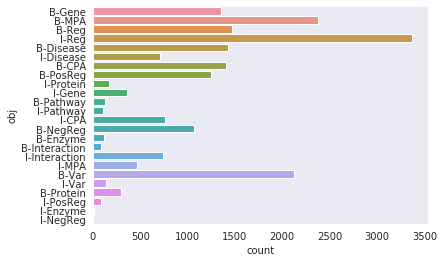

In [13]:
sns.countplot(y = "obj", data=data_df[data_df['obj'] != 'O'])

## Deep Learning - LSTM | PyTorch

### Create a list of words and output tags

In [14]:
words = list(set(data_df["word"].values))
words.append("ENDPAD")
n_words = len(words)
print(f"Number of words = {n_words}")

Number of words = 9745


In [15]:
tags = list(set(data_df["obj"].values))
n_tags = len(tags)
print(f"Number of tags = {n_tags}")

Number of tags = 25


### Data Loader

In [16]:
class LoadData(Dataset):
    
    def __init__(self, data):
        self.data = data
        
        agg_func = lambda x: [(w, t) for w, t in zip(x['word'].values.tolist(), x['obj'].values.tolist())]
        
        self.grouped_data = self.data.groupby('doc_id').apply(agg_func)
        self.sentences = [x for x in self.grouped_data]
        
    def __getitem__(self, index):
        return self.sentences[index]
        
    def __len__ (self):
        return len(self.X_data)

    


class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

    
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)



In [17]:
loaded_data = LoadData(data_df)

### Extract Sentences

In [18]:
sentence_tag_list = loaded_data.sentences

### Number of words per sentence.

In [19]:
# plt.hist([len(s) for s in sentence_tag_list], bins=20)
# plt.show()

Majority of the sentences have 250 words per sentence. So, we'll set the limit for max words as 250. Each sentence will be padded or stripped down to maintain 250 words.

### Create word/tag to id dictionary.

In [20]:
max_len = 250
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [21]:
print(f"ID for the word 'variations' in the dictionary is: {word2idx['variations']}")
print(f"ID for the tag 'O' in the dictionary is: {tag2idx['O']}")

ID for the word 'variations' in the dictionary is: 163
ID for the tag 'O' in the dictionary is: 19


### Pad sentences.

In [22]:
X = [[word2idx[w[0]] for w in s] for s in sentence_tag_list]

In [23]:
# X = [torch.tensor(i) for i in X]
# X = pad_sequence(sequences=X, padding_value=9999)

In [24]:
from keras.preprocessing.sequence import pad_sequences
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words - 1)

Using TensorFlow backend.


### Pad tags.

In [25]:
y = [[tag2idx[w[1]] for w in s] for s in sentence_tag_list]

In [26]:
# y = [torch.tensor(i) for i in y]
# y = pad_sequence(sequences=y, padding_value=0)

In [27]:
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

### Split data into train and test sets.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

### Define NN architecture.

In [29]:
train_data = TrainData(torch.Tensor(X_train).to(torch.int64), torch.Tensor(y_train).to(torch.long))
test_data = TestData(torch.Tensor(X_test).to(torch.int64))

In [30]:
EMBEDDING_DIM = 100
HIDDEN_DIM = 100
LEARNING_RATE = 0.01
NUM_EPOCHS = 100

In [31]:
class NerTagger(nn.Module):
    
    def __init__(self, embedding_dim, hidden_dim, vocab_size, target_size):
        super(NerTagger, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.linear = nn.Linear(hidden_dim, target_size)
        
    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        linear_out = self.linear(lstm_out.view(len(sentence), -1))
        scores = F.log_softmax(linear_out, dim = 1)
        
        return scores        

In [32]:
model = NerTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word2idx), len(tag2idx))
print(model)
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.1)

NerTagger(
  (word_embeddings): Embedding(9745, 100)
  (lstm): LSTM(100, 100)
  (linear): Linear(in_features=100, out_features=25, bias=True)
)


### Train the model.

In [33]:
with torch.no_grad():
    inputs = train_data[0][0]
    tag_scores = model(inputs)
    print(tag_scores)

tensor([[-3.1276, -3.1502, -3.2321,  ..., -3.2104, -3.2344, -3.3357],
        [-3.1630, -3.2606, -3.2435,  ..., -3.1712, -3.3694, -3.2855],
        [-3.1224, -3.2160, -3.3242,  ..., -3.0756, -3.3985, -3.2483],
        ...,
        [-3.0190, -2.9952, -3.4749,  ..., -3.1186, -3.3672, -3.5118],
        [-3.0190, -2.9952, -3.4749,  ..., -3.1186, -3.3672, -3.5118],
        [-3.0190, -2.9952, -3.4749,  ..., -3.1186, -3.3672, -3.5118]])


In [39]:
accuracy_list = []
loss_list = []
interval = round(len(train_data) / 100.)
e_interval = round(NUM_EPOCHS / 10.)

print("Training Started.")

for epoch in range(NUM_EPOCHS):
    acc = 0
    loss = 0
    for sentence, tags in train_data:

        model.zero_grad()
        
        tag_scores = model(sentence)

        loss = loss_function(tag_scores, tags)
        loss.backward()
        optimizer.step()
        
        loss += loss.item()
        _, indices = torch.max(tag_scores, 1)
        
#         acc += torch.mean(torch.tensor(tags == indices, dtype=torch.float))
        
#         if i % interval == 0:
#             print("Epoch {} Running;\t{}% Complete".format(epoch + 1, i / interval), end = "\r", flush = True)
            
        loss = loss / len(train_data)
#         acc = acc / len(train_data)
        loss_list.append(float(loss))
#         accuracy_list.append(float(acc))
        
        if (epoch + 1) % e_interval == 0:
            print("Epoch {} Completed,\tLoss {}\tAccuracy: {}".format(epoch + 1, np.mean(loss_list[-e_interval:]), np.mean(accuracy_list[-e_interval:])))

print("Training Over.")

Training Started.


/home/akshaj/anaconda3/envs/nlp/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/akshaj/anaconda3/envs/nlp/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 10 Completed,	Loss 0.004809314874000848	Accuracy: nan
Epoch 10 Completed,	Loss 0.004646583762951195	Accuracy: nan
Epoch 10 Completed,	Loss 0.0047488024458289145	Accuracy: nan
Epoch 10 Completed,	Loss 0.004843101324513555	Accuracy: nan
Epoch 10 Completed,	Loss 0.004977439483627677	Accuracy: nan
Epoch 10 Completed,	Loss 0.0050521936733275655	Accuracy: nan
Epoch 10 Completed,	Loss 0.004920450551435351	Accuracy: nan
Epoch 10 Completed,	Loss 0.004956336691975594	Accuracy: nan
Epoch 10 Completed,	Loss 0.0046279221074655656	Accuracy: nan
Epoch 10 Completed,	Loss 0.00493938431609422	Accuracy: nan
Epoch 10 Completed,	Loss 0.004797960491850972	Accuracy: nan
Epoch 10 Completed,	Loss 0.004695898946374654	Accuracy: nan
Epoch 10 Completed,	Loss 0.004743838869035244	Accuracy: nan
Epoch 10 Completed,	Loss 0.004462854145094753	Accuracy: nan
Epoch 10 Completed,	Loss 0.004406414367258549	Accuracy: nan
Epoch 10 Completed,	Loss 0.00410775332711637	Accuracy: nan
Epoch 10 Completed,	Loss 0.004047214146

Epoch 10 Completed,	Loss 0.004390556155703962	Accuracy: nan
Epoch 10 Completed,	Loss 0.004242036212235689	Accuracy: nan
Epoch 10 Completed,	Loss 0.004155948385596275	Accuracy: nan
Epoch 10 Completed,	Loss 0.003916799044236541	Accuracy: nan
Epoch 10 Completed,	Loss 0.003926856350153685	Accuracy: nan
Epoch 10 Completed,	Loss 0.004044581460766495	Accuracy: nan
Epoch 10 Completed,	Loss 0.004168495046906173	Accuracy: nan
Epoch 10 Completed,	Loss 0.004043453489430249	Accuracy: nan
Epoch 10 Completed,	Loss 0.0041127615375444295	Accuracy: nan
Epoch 10 Completed,	Loss 0.004130676155909896	Accuracy: nan
Epoch 10 Completed,	Loss 0.004318220634013414	Accuracy: nan
Epoch 10 Completed,	Loss 0.004434857540763915	Accuracy: nan
Epoch 10 Completed,	Loss 0.004532460984773934	Accuracy: nan
Epoch 10 Completed,	Loss 0.0047691882820799945	Accuracy: nan
Epoch 10 Completed,	Loss 0.00469216147903353	Accuracy: nan
Epoch 10 Completed,	Loss 0.0046498443000018595	Accuracy: nan
Epoch 10 Completed,	Loss 0.00430853567

Epoch 20 Completed,	Loss 0.002564216940663755	Accuracy: nan
Epoch 20 Completed,	Loss 0.0025362329790368674	Accuracy: nan
Epoch 20 Completed,	Loss 0.0023863023146986962	Accuracy: nan
Epoch 20 Completed,	Loss 0.00239302406553179	Accuracy: nan
Epoch 20 Completed,	Loss 0.002383610140532255	Accuracy: nan
Epoch 20 Completed,	Loss 0.0020626452460419387	Accuracy: nan
Epoch 20 Completed,	Loss 0.0021405194129329175	Accuracy: nan
Epoch 20 Completed,	Loss 0.0022494926059152933	Accuracy: nan
Epoch 20 Completed,	Loss 0.002204508677823469	Accuracy: nan
Epoch 20 Completed,	Loss 0.0020504044427070768	Accuracy: nan
Epoch 20 Completed,	Loss 0.0019631804956588895	Accuracy: nan
Epoch 20 Completed,	Loss 0.0019030860566999763	Accuracy: nan
Epoch 20 Completed,	Loss 0.0020623157906811684	Accuracy: nan
Epoch 20 Completed,	Loss 0.0021294700854923576	Accuracy: nan
Epoch 20 Completed,	Loss 0.00210196694242768	Accuracy: nan
Epoch 20 Completed,	Loss 0.002224510349333286	Accuracy: nan
Epoch 20 Completed,	Loss 0.00212

Epoch 20 Completed,	Loss 0.0022356170462444424	Accuracy: nan
Epoch 20 Completed,	Loss 0.002297113090753555	Accuracy: nan
Epoch 20 Completed,	Loss 0.002382094203494489	Accuracy: nan
Epoch 20 Completed,	Loss 0.002511873631738126	Accuracy: nan
Epoch 20 Completed,	Loss 0.0028051445726305245	Accuracy: nan
Epoch 20 Completed,	Loss 0.0028101399424485863	Accuracy: nan
Epoch 20 Completed,	Loss 0.0026862417696975173	Accuracy: nan
Epoch 20 Completed,	Loss 0.0027092048549093306	Accuracy: nan
Epoch 20 Completed,	Loss 0.0026956386980600657	Accuracy: nan
Epoch 20 Completed,	Loss 0.0027838227688334882	Accuracy: nan
Epoch 20 Completed,	Loss 0.002927572838962078	Accuracy: nan
Epoch 20 Completed,	Loss 0.00290484051220119	Accuracy: nan
Epoch 20 Completed,	Loss 0.0027981043560430406	Accuracy: nan
Epoch 20 Completed,	Loss 0.0027752585941925646	Accuracy: nan
Epoch 20 Completed,	Loss 0.0026029563741758466	Accuracy: nan
Epoch 20 Completed,	Loss 0.0026973653584718704	Accuracy: nan
Epoch 20 Completed,	Loss 0.002

Epoch 30 Completed,	Loss 0.00151101901428774	Accuracy: nan
Epoch 30 Completed,	Loss 0.0014786866260692478	Accuracy: nan
Epoch 30 Completed,	Loss 0.0014662103028967976	Accuracy: nan
Epoch 30 Completed,	Loss 0.001464033976662904	Accuracy: nan
Epoch 30 Completed,	Loss 0.0014530717860907316	Accuracy: nan
Epoch 30 Completed,	Loss 0.0014538251096382737	Accuracy: nan
Epoch 30 Completed,	Loss 0.00147891208762303	Accuracy: nan
Epoch 30 Completed,	Loss 0.0016004513949155808	Accuracy: nan
Epoch 30 Completed,	Loss 0.0015457231900654733	Accuracy: nan
Epoch 30 Completed,	Loss 0.0015330360038205981	Accuracy: nan
Epoch 30 Completed,	Loss 0.0016061905771493912	Accuracy: nan
Epoch 30 Completed,	Loss 0.0015098647141712717	Accuracy: nan
Epoch 30 Completed,	Loss 0.0014887166369589977	Accuracy: nan
Epoch 30 Completed,	Loss 0.0014900310939992777	Accuracy: nan
Epoch 30 Completed,	Loss 0.0014275914916652254	Accuracy: nan
Epoch 30 Completed,	Loss 0.0013659839678439312	Accuracy: nan
Epoch 30 Completed,	Loss 0.00

Epoch 40 Completed,	Loss 0.0010965729830786585	Accuracy: nan
Epoch 40 Completed,	Loss 0.001119209872558713	Accuracy: nan
Epoch 40 Completed,	Loss 0.001039887039223686	Accuracy: nan
Epoch 40 Completed,	Loss 0.001202732778619975	Accuracy: nan
Epoch 40 Completed,	Loss 0.0011788358620833605	Accuracy: nan
Epoch 40 Completed,	Loss 0.0011519791092723607	Accuracy: nan
Epoch 40 Completed,	Loss 0.0011581441678572447	Accuracy: nan
Epoch 40 Completed,	Loss 0.0010305574454832823	Accuracy: nan
Epoch 40 Completed,	Loss 0.0009925694321282208	Accuracy: nan
Epoch 40 Completed,	Loss 0.0009158735105302185	Accuracy: nan
Epoch 40 Completed,	Loss 0.0009015501535031944	Accuracy: nan
Epoch 40 Completed,	Loss 0.0010201497410889716	Accuracy: nan
Epoch 40 Completed,	Loss 0.001100973249413073	Accuracy: nan
Epoch 40 Completed,	Loss 0.000961094192462042	Accuracy: nan
Epoch 40 Completed,	Loss 0.001041841576807201	Accuracy: nan
Epoch 40 Completed,	Loss 0.0011341955920215695	Accuracy: nan
Epoch 40 Completed,	Loss 0.001

Epoch 40 Completed,	Loss 0.0007862191239837557	Accuracy: nan
Epoch 40 Completed,	Loss 0.0008102324965875596	Accuracy: nan
Epoch 40 Completed,	Loss 0.0008170148124918341	Accuracy: nan
Epoch 40 Completed,	Loss 0.0007913605077192187	Accuracy: nan
Epoch 40 Completed,	Loss 0.0008029437274672091	Accuracy: nan
Epoch 40 Completed,	Loss 0.0008429190027527511	Accuracy: nan
Epoch 40 Completed,	Loss 0.0008828896621707827	Accuracy: nan
Epoch 40 Completed,	Loss 0.0009519930055830628	Accuracy: nan
Epoch 40 Completed,	Loss 0.000980260071810335	Accuracy: nan
Epoch 40 Completed,	Loss 0.001061134081101045	Accuracy: nan
Epoch 40 Completed,	Loss 0.0009689675469417125	Accuracy: nan
Epoch 40 Completed,	Loss 0.0009626933082472533	Accuracy: nan
Epoch 40 Completed,	Loss 0.0009073708759387955	Accuracy: nan
Epoch 40 Completed,	Loss 0.0009104864351684227	Accuracy: nan
Epoch 40 Completed,	Loss 0.0009483205416472628	Accuracy: nan
Epoch 40 Completed,	Loss 0.0009926873870426788	Accuracy: nan
Epoch 40 Completed,	Loss 0

Epoch 50 Completed,	Loss 0.0006301742701907642	Accuracy: nan
Epoch 50 Completed,	Loss 0.0006353600401780568	Accuracy: nan
Epoch 50 Completed,	Loss 0.0005480385127157206	Accuracy: nan
Epoch 50 Completed,	Loss 0.0005888972114917124	Accuracy: nan
Epoch 50 Completed,	Loss 0.0006157978397823172	Accuracy: nan
Epoch 50 Completed,	Loss 0.0006132136350061046	Accuracy: nan
Epoch 50 Completed,	Loss 0.000544453939437517	Accuracy: nan
Epoch 50 Completed,	Loss 0.0005182850149139995	Accuracy: nan
Epoch 50 Completed,	Loss 0.0004883537800196791	Accuracy: nan
Epoch 50 Completed,	Loss 0.0005385044878494227	Accuracy: nan
Epoch 50 Completed,	Loss 0.0005294541686453158	Accuracy: nan
Epoch 50 Completed,	Loss 0.0005383573767176131	Accuracy: nan
Epoch 50 Completed,	Loss 0.0005709651290089823	Accuracy: nan
Epoch 50 Completed,	Loss 0.000540286501927767	Accuracy: nan
Epoch 50 Completed,	Loss 0.0005884386671823449	Accuracy: nan
Epoch 50 Completed,	Loss 0.0005616088441456668	Accuracy: nan
Epoch 50 Completed,	Loss 0

Epoch 50 Completed,	Loss 0.000757864027400501	Accuracy: nan
Epoch 50 Completed,	Loss 0.0008048494666581974	Accuracy: nan
Epoch 50 Completed,	Loss 0.0008385672583244741	Accuracy: nan
Epoch 50 Completed,	Loss 0.0007388013065792621	Accuracy: nan
Epoch 50 Completed,	Loss 0.0007447590032825246	Accuracy: nan
Epoch 50 Completed,	Loss 0.0007519249251345172	Accuracy: nan
Epoch 50 Completed,	Loss 0.0007688013865845278	Accuracy: nan
Epoch 50 Completed,	Loss 0.000776143159600906	Accuracy: nan
Epoch 50 Completed,	Loss 0.0007666342338779941	Accuracy: nan
Epoch 50 Completed,	Loss 0.0006990540801780299	Accuracy: nan
Epoch 50 Completed,	Loss 0.0007101451948983595	Accuracy: nan
Epoch 50 Completed,	Loss 0.0007310211105505005	Accuracy: nan
Epoch 50 Completed,	Loss 0.0007247325003845618	Accuracy: nan
Epoch 50 Completed,	Loss 0.0007198766194051132	Accuracy: nan
Epoch 50 Completed,	Loss 0.0007058076880639419	Accuracy: nan
Epoch 50 Completed,	Loss 0.0006830683094449341	Accuracy: nan
Epoch 50 Completed,	Loss 0

Epoch 60 Completed,	Loss 0.00045854428608436135	Accuracy: nan
Epoch 60 Completed,	Loss 0.0004609312512911856	Accuracy: nan
Epoch 60 Completed,	Loss 0.0004618922452209517	Accuracy: nan
Epoch 60 Completed,	Loss 0.0004789558821357787	Accuracy: nan
Epoch 60 Completed,	Loss 0.0005301135446643457	Accuracy: nan
Epoch 60 Completed,	Loss 0.0005112762242788449	Accuracy: nan
Epoch 60 Completed,	Loss 0.0005071186373243108	Accuracy: nan
Epoch 60 Completed,	Loss 0.000520859588868916	Accuracy: nan
Epoch 60 Completed,	Loss 0.00049586542409088	Accuracy: nan
Epoch 60 Completed,	Loss 0.0005091439419629751	Accuracy: nan
Epoch 60 Completed,	Loss 0.0005196852329390822	Accuracy: nan
Epoch 60 Completed,	Loss 0.0005056940233771456	Accuracy: nan
Epoch 60 Completed,	Loss 0.00047936563751136416	Accuracy: nan
Epoch 60 Completed,	Loss 0.0004883318117208546	Accuracy: nan
Epoch 60 Completed,	Loss 0.00048222356381302236	Accuracy: nan
Epoch 60 Completed,	Loss 0.0004464477733563399	Accuracy: nan
Epoch 60 Completed,	Loss

Epoch 70 Completed,	Loss 0.000360135570372222	Accuracy: nan
Epoch 70 Completed,	Loss 0.00045533481388702055	Accuracy: nan
Epoch 70 Completed,	Loss 0.0004484453260374721	Accuracy: nan
Epoch 70 Completed,	Loss 0.0004476219786738511	Accuracy: nan
Epoch 70 Completed,	Loss 0.0004463169396331068	Accuracy: nan
Epoch 70 Completed,	Loss 0.00037677268774132243	Accuracy: nan
Epoch 70 Completed,	Loss 0.0003588696497899946	Accuracy: nan
Epoch 70 Completed,	Loss 0.00033946497351280416	Accuracy: nan
Epoch 70 Completed,	Loss 0.00033848457896965554	Accuracy: nan
Epoch 70 Completed,	Loss 0.0003779639162530657	Accuracy: nan
Epoch 70 Completed,	Loss 0.00040836258558556436	Accuracy: nan
Epoch 70 Completed,	Loss 0.00032366759260185065	Accuracy: nan
Epoch 70 Completed,	Loss 0.0003476405778201297	Accuracy: nan
Epoch 70 Completed,	Loss 0.00041142034460790456	Accuracy: nan
Epoch 70 Completed,	Loss 0.0004063828440848738	Accuracy: nan
Epoch 70 Completed,	Loss 0.0004296940314816311	Accuracy: nan
Epoch 70 Completed

Epoch 70 Completed,	Loss 0.00027558043439057656	Accuracy: nan
Epoch 70 Completed,	Loss 0.0002793913510686252	Accuracy: nan
Epoch 70 Completed,	Loss 0.00027288287310511805	Accuracy: nan
Epoch 70 Completed,	Loss 0.00027546747951419094	Accuracy: nan
Epoch 70 Completed,	Loss 0.00028438238296075725	Accuracy: nan
Epoch 70 Completed,	Loss 0.00029325837022042833	Accuracy: nan
Epoch 70 Completed,	Loss 0.00031548847546218893	Accuracy: nan
Epoch 70 Completed,	Loss 0.0003188757509633433	Accuracy: nan
Epoch 70 Completed,	Loss 0.00034768324985634536	Accuracy: nan
Epoch 70 Completed,	Loss 0.00030807210423517973	Accuracy: nan
Epoch 70 Completed,	Loss 0.000305884302360937	Accuracy: nan
Epoch 70 Completed,	Loss 0.00028341328288661316	Accuracy: nan
Epoch 70 Completed,	Loss 0.0002870763491955586	Accuracy: nan
Epoch 70 Completed,	Loss 0.0003154925288981758	Accuracy: nan
Epoch 70 Completed,	Loss 0.00033168964000651613	Accuracy: nan
Epoch 70 Completed,	Loss 0.00033604863419895993	Accuracy: nan
Epoch 70 Compl

Epoch 80 Completed,	Loss 0.00026070971143781206	Accuracy: nan
Epoch 80 Completed,	Loss 0.00026228363494738003	Accuracy: nan
Epoch 80 Completed,	Loss 0.00022641269679297694	Accuracy: nan
Epoch 80 Completed,	Loss 0.00025727549436851407	Accuracy: nan
Epoch 80 Completed,	Loss 0.0002708082291064784	Accuracy: nan
Epoch 80 Completed,	Loss 0.0002707622741581872	Accuracy: nan
Epoch 80 Completed,	Loss 0.0002300820386153646	Accuracy: nan
Epoch 80 Completed,	Loss 0.0002164981095120311	Accuracy: nan
Epoch 80 Completed,	Loss 0.00020554362854454666	Accuracy: nan
Epoch 80 Completed,	Loss 0.00023345000081462786	Accuracy: nan
Epoch 80 Completed,	Loss 0.00022729727788828313	Accuracy: nan
Epoch 80 Completed,	Loss 0.00023044347763061522	Accuracy: nan
Epoch 80 Completed,	Loss 0.0002423902493319474	Accuracy: nan
Epoch 80 Completed,	Loss 0.00021452680812217295	Accuracy: nan
Epoch 80 Completed,	Loss 0.00024773268814897164	Accuracy: nan
Epoch 80 Completed,	Loss 0.00023544946307083592	Accuracy: nan
Epoch 80 Comp

Epoch 80 Completed,	Loss 0.00030004145301063543	Accuracy: nan
Epoch 80 Completed,	Loss 0.0003084766307438258	Accuracy: nan
Epoch 80 Completed,	Loss 0.0003236764212488197	Accuracy: nan
Epoch 80 Completed,	Loss 0.00033876883680932223	Accuracy: nan
Epoch 80 Completed,	Loss 0.0002937239012680948	Accuracy: nan
Epoch 80 Completed,	Loss 0.00029611999343615025	Accuracy: nan
Epoch 80 Completed,	Loss 0.00029738215380348265	Accuracy: nan
Epoch 80 Completed,	Loss 0.0003046498924959451	Accuracy: nan
Epoch 80 Completed,	Loss 0.000310936123423744	Accuracy: nan
Epoch 80 Completed,	Loss 0.00030246309033827857	Accuracy: nan
Epoch 80 Completed,	Loss 0.0002703482736251317	Accuracy: nan
Epoch 80 Completed,	Loss 0.0002810907011735253	Accuracy: nan
Epoch 80 Completed,	Loss 0.00030966858757892625	Accuracy: nan
Epoch 80 Completed,	Loss 0.00030250160343712194	Accuracy: nan
Epoch 80 Completed,	Loss 0.00030823604465695097	Accuracy: nan
Epoch 80 Completed,	Loss 0.00030434686050284654	Accuracy: nan
Epoch 80 Complet

Epoch 90 Completed,	Loss 0.00023480273375753313	Accuracy: nan
Epoch 90 Completed,	Loss 0.00020994369988329707	Accuracy: nan
Epoch 90 Completed,	Loss 0.00020387980475788936	Accuracy: nan
Epoch 90 Completed,	Loss 0.00020256798161426558	Accuracy: nan
Epoch 90 Completed,	Loss 0.00020157258841209115	Accuracy: nan
Epoch 90 Completed,	Loss 0.00019889400573447347	Accuracy: nan
Epoch 90 Completed,	Loss 0.00020629520295187831	Accuracy: nan
Epoch 90 Completed,	Loss 0.0002446306316414848	Accuracy: nan
Epoch 90 Completed,	Loss 0.0002339231374207884	Accuracy: nan
Epoch 90 Completed,	Loss 0.0002302319262525998	Accuracy: nan
Epoch 90 Completed,	Loss 0.00023185325262602418	Accuracy: nan
Epoch 90 Completed,	Loss 0.00022212538133317138	Accuracy: nan
Epoch 90 Completed,	Loss 0.00023903087530925405	Accuracy: nan
Epoch 90 Completed,	Loss 0.0002432844452414429	Accuracy: nan
Epoch 90 Completed,	Loss 0.00024114474617817905	Accuracy: nan
Epoch 90 Completed,	Loss 0.00023093356248864437	Accuracy: nan
Epoch 90 Com

Epoch 100 Completed,	Loss 0.0001831851390306838	Accuracy: nan
Epoch 100 Completed,	Loss 0.00018822880374500529	Accuracy: nan
Epoch 100 Completed,	Loss 0.00018065949843730776	Accuracy: nan
Epoch 100 Completed,	Loss 0.00017776593740563839	Accuracy: nan
Epoch 100 Completed,	Loss 0.00016454100659757387	Accuracy: nan
Epoch 100 Completed,	Loss 0.00022600825723202435	Accuracy: nan
Epoch 100 Completed,	Loss 0.00022340418909152504	Accuracy: nan
Epoch 100 Completed,	Loss 0.00022188290786289143	Accuracy: nan
Epoch 100 Completed,	Loss 0.00022076088753237856	Accuracy: nan
Epoch 100 Completed,	Loss 0.00018329743506910744	Accuracy: nan
Epoch 100 Completed,	Loss 0.00017705934624245856	Accuracy: nan
Epoch 100 Completed,	Loss 0.00017028826732712332	Accuracy: nan
Epoch 100 Completed,	Loss 0.00017174814456666354	Accuracy: nan
Epoch 100 Completed,	Loss 0.000188249886923586	Accuracy: nan
Epoch 100 Completed,	Loss 0.00020036646965309045	Accuracy: nan
Epoch 100 Completed,	Loss 0.00014401713342522272	Accuracy:

Epoch 100 Completed,	Loss 0.00016064214578364043	Accuracy: nan
Epoch 100 Completed,	Loss 0.00015932104506646282	Accuracy: nan
Epoch 100 Completed,	Loss 0.00014980727719375863	Accuracy: nan
Epoch 100 Completed,	Loss 0.00011512113851495088	Accuracy: nan
Epoch 100 Completed,	Loss 0.00010458429242135025	Accuracy: nan
Epoch 100 Completed,	Loss 0.0001188599671877455	Accuracy: nan
Epoch 100 Completed,	Loss 0.00012372060882626101	Accuracy: nan
Epoch 100 Completed,	Loss 0.00012656237959163263	Accuracy: nan
Epoch 100 Completed,	Loss 0.0001248313856194727	Accuracy: nan
Epoch 100 Completed,	Loss 0.00012728530127787964	Accuracy: nan
Epoch 100 Completed,	Loss 0.00012934696569573135	Accuracy: nan
Epoch 100 Completed,	Loss 0.00013443127245409413	Accuracy: nan
Epoch 100 Completed,	Loss 0.00014460920428973622	Accuracy: nan
Epoch 100 Completed,	Loss 0.0001454813354939688	Accuracy: nan
Epoch 100 Completed,	Loss 0.00015767219883855432	Accuracy: nan
Epoch 100 Completed,	Loss 0.00014249273372115567	Accuracy:

### Train Acc and Val Acc.

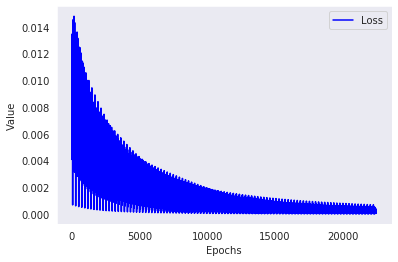

In [44]:
import matplotlib.pyplot as plt
# plt.plot(accuracy_list, c="red", label ="Accuracy")
# plt.xlabel("Epochs")
# plt.ylabel("Value")
# plt.legend()
# plt.show()

plt.plot(loss_list, c="blue", label ="Loss")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()


### Classification Metrics.

In [41]:
y_pred_list = []
with torch.no_grad():
    for i in range(25):        
        y_pred = model(test_data[i])
        _, y_pred = torch.max(y_pred, 1)
        y_pred = np.array(y_pred)
        
        y_pred_list.append(y_pred)


    
print(metrics.flat_classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00        41
           4       0.94      0.36      0.52        45
           5       1.00      0.92      0.96        12
           6       0.79      0.48      0.60       130
           7       0.94      0.90      0.92       129
           8       0.93      0.91      0.92        47
          10       0.90      0.88      0.89       227
          11       0.98      0.97      0.98       179
          12       1.00      1.00      1.00        10
          13       0.99      0.94      0.96       144
          14       0.92      0.79      0.85       162
          15       1.00      1.00      1.00        84
          16       0.92      0.85      0.89        95
          17       0.93      0.90      0.92        62
          18       0.88    

/home/akshaj/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/akshaj/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/akshaj/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Try out the model

In [43]:
tags = list(set(data_df["obj"].values))

i = 24
with torch.no_grad():
    y_pred = model(test_data[i])
    
    _, y_pred = torch.max(y_pred, 1)
    
    print('{:26}: {:15}: {}\n'.format("Word", "Pred", "Actual"))
    
    for w, pred, actual in zip(test_data[i], y_pred, y_test[i]):
        pprint("{:25}: {:15}: {}".format(words[w], tags[pred], tags[actual]))

Word                      : Pred           : Actual

'Lethal                   : O              : O'
'digenic                  : O              : O'
'mutations                : B-Var          : B-Var'
'in                       : I-Reg          : I-Reg'
'the                      : O              : O'
'K(+)                     : B-MPA          : O'
'channels                 : O              : O'
'Kir41                    : O              : O'
'(KCNJ10)                 : O              : O'
'and                      : O              : O'
'SLACK                    : O              : O'
'(KCNT1)                  : O              : O'
'associated               : B-Reg          : B-Reg'
'with                     : I-Interaction  : I-Interaction'
'severe-disabling         : O              : O'
'seizures                 : B-Disease      : B-Disease'
'and                      : O              : O'
'neurodevelopmental       : B-Disease      : B-Disease'
'delay                    : I-Disease      